In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
# import numpy as np
# import os
# from functools import partial
# import seaborn as sns
# import plotly.graph_objects as go
# import pandas as pd
# import dask.dataframe as dd
# import matplotlib.pyplot as plt
# import sys
# import pickle
# from pathlib import Path


# # hex2vec
# HOME = os.environ["HOME"]

# sys.path.insert(0, f"{HOME}/hex2vec")

# # add codebase
# sys.path.insert(0, f"/gcsmount-notebook/codebase")

# from src.data.make_dataset import h3_to_polygon
# import urban_tools.constants as uc
# from urban_tools.hex_pipeline import RouteHexHandler, TestTrainManager
# from urban_tools.pipelines import route_hex_pipeline


# ## Read in the Delivery DataFrame
# p = Path("/gcsmount-research-data-staging/osmnx-cities/hexed-routes/debug-multi-synthetic-tags/hh.pkl")
# hh = RouteHexHandler.from_pickle(p)
# # embedding_df = pd.read_pickle("/gcsmount-research-data-staging/osmnx-cities/hexed-complete/Boston, MA/boston_embedding.pkl")

# ### Remove Super Tags
# # hh.drop_super_tags()
# ### Remove Sub Tags
# # hh = hh.drop_sub_tags()
# ### Filter for only H3 with > X Data Points

# hh = hh.filter_hex_occurance(20)
# ## Drop Unecessary Columns
# hh.other_tags
# ### Drop Chicago
# # print(tagged_df.shape[0].compute(), tagged_df.shape[1])
# # tagged_df = tagged_df.loc[~tagged_df["city"].str.contains("Chicago")]
# # filter for only Boston
# hh.df = hh.df.loc[hh.df.city.str.contains("Boston")]
# # print(tagged_df.shape[0].compute(), tagged_df.shape[1])

# ## Data Preprocessing: Scaling and Splitting into train test


# # create a grouped dataframe
# tagged_df = hh.df.groupby("h3").agg({
#     "planned_service_time_log": "mean",
#     **{
#         tag: "first"
#         for tag in hh.all_tags
#     }
# })


# from sklearn.preprocessing import RobustScaler

# tt = TestTrainManager(
#     tagged_df,
#     x_col=hh.all_tags,
#     y_col=["planned_service_time_log"],
#     scaler=RobustScaler,
#     grouped=True,
# )
# tt.split_test_train(train_size=0.8, random_seed=6781)


# tt.scale_test_train()
# tt.build_test_df(agg=False)

In [3]:
import os
import sys
import pickle
from pathlib import Path
import torch; torch.manual_seed(0)
import torch.nn as nn
import torch.nn.functional as F
import torch.utils
import torch.distributions
import torchvision
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from functools import partial
import seaborn as sns
import gc
from numpy.random import binomial
from numpy.random import normal

import pandas as pd
import seaborn as sns

# %reset -s -f
import os
from functools import partial
import logging

# hex2vec
HOME = os.environ["HOME"]

sys.path.insert(0, f"{HOME}/hex2vec")

# add codebase
sys.path.insert(0, f"/gcsmount-notebook/codebase")

from src.data.make_dataset import h3_to_polygon
import urban_tools.constants as uc
from urban_tools.hex_pipeline import RouteHexHandler, TestTrainManager
from urban_tools.pipelines import route_hex_pipeline

p = Path("/gcsmount-research-data-staging/osmnx-cities/hexed-routes/debug-multi-synthetic-tags/hh.pkl")
hh = RouteHexHandler.from_pickle(p)
# embedding_df = pd.read_pickle("/gcsmount-research-data-staging/osmnx-cities/hexed-complete/Boston, MA/boston_embedding.pkl")

### Filter for only H3 with > X Data Points
hh = hh.filter_hex_occurance(20)
## Drop Unecessary Columns
hh.other_tags

## Data Preprocessing: Scaling and Splitting into train test

#### Create the Test-Train Manager
# filter for only Boston
from sklearn.preprocessing import RobustScaler
hh.df = hh.df.loc[hh.df.city.str.contains("Boston")]
tt = TestTrainManager(
        hh.df,
        scaler=RobustScaler,
        x_col=hh.all_tags,
        y_col=hh.df.columns.intersection(["planned_service_time_log"]),
    )

tt.split_test_train(random_seed=12323)
tt.scale_test_train()
tt.build_test_df()
train = pd.concat([tt.X_train, tt.Y_train], axis=1, copy=True)
test = pd.concat([tt.X_test, tt.Y_test.loc, tt.Y_test.scale], axis=1, copy=True)

print(f'Training Data shape is {tt.X_train.shape}')
print(f'testing Data shape is {tt.X_test.shape}')

del hh
gc.collect()

# convert a pandas dataframe to a pytorch dataset
class PandasDataset(torch.utils.data.Dataset):
    def __init__(self, x_df, y_df):
        self._x_df = x_df.values.astype(np.float32)
        self._y_df = y_df.values.astype(np.float32).ravel()

    def __len__(self):
        return len(self._x_df)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        return self._x_df[idx], self._y_df[idx]

Training Data shape is (28337, 674)
testing Data shape is (240, 674)


In [4]:
import sys
sys.path.append('/home/ext_navish_iitkgp_gmail_com/ganRegression/')

In [5]:
import importlib

import dataset, metrics, plotting, config, network
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from models import cgan_model
import numpy as np
import random

importlib.reload(network)
importlib.reload(dataset)
importlib.reload(metrics)
importlib.reload(plotting)
importlib.reload(config)
importlib.reload(cgan_model)

2022-11-18 15:55:43.793458: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-18 15:55:44.022365: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-11-18 15:55:44.022400: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-11-18 15:55:44.057951: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-18 15:55:44.769827: W tensorflow/stream_executor/platform/de

<module 'models.cgan_model' from '/home/ext_navish_iitkgp_gmail_com/ganRegression/models/cgan_model.py'>

In [6]:
import os

# dataset_config = config.DatasetConfig(scenario="census-house")
dataset_config = config.DatasetConfig(scenario="amazon-boston-dataset")

assert(dataset_config.scenario == "CA-housing"
      or dataset_config.scenario == "ailerons"
      or dataset_config.scenario == "CA-housing-single"
      or dataset_config.scenario == "comp-activ"
      or dataset_config.scenario == "pumadyn"
      or dataset_config.scenario == "bank"
      or dataset_config.scenario == "abalone"
      or dataset_config.scenario == "abalone"
      or dataset_config.scenario == "amazon-boston-dataset")
    #   or dataset_config.scenario == "census-house-single"
fig_dir = f"/gcsmount-notebook/navish/RegressionNN/figures/{dataset_config.scenario}"

try:
    os.mkdir(fig_dir)
    print(f"Directory {fig_dir} created ") 
except FileExistsError:
    print(f"Directory {fig_dir} already exists replacing files in this notebook")

Directory /gcsmount-notebook/navish/RegressionNN/figures/amazon-boston-dataset already exists replacing files in this notebook


In [7]:
random_seed = 1985

exp_config = config.Config(
    model=config.ModelConfig(activation="elu", lr_gen=1e-3, lr_disc=1e-4, dec_gen=0, dec_disc=0, 
                                optim_gen="Adam", optim_disc="Adam", z_input_size=1, random_seed=random_seed),
    training=config.TrainingConfig(n_epochs=500, batch_size=128, n_samples=100),
    dataset=dataset_config,
    run=config.RunConfig(save_fig=1)
)

In [8]:
# Set random seed
np.random.seed(exp_config.model.random_seed)
random.seed(exp_config.model.random_seed)

import tensorflow as tf
tf.random.set_seed(exp_config.model.random_seed)

# gpu = tf.config.experimental.list_physical_devices('CPU')
# tf.config.experimental.set_memory_growth(gpu, True)

In [9]:
X_train, y_train, X_test, y_test = tt.X_train.values, tt.Y_train.values.ravel(), tt.X_test.values, tt.Y_test.loc.values

In [10]:
X_train.shape, X_test.shape

((28337, 674), (240, 674))

# XGBoost

##### Tuning XGBOOST

In [11]:
# from sklearn.model_selection import GridSearchCV, KFold
# import xgboost as xgb

# # XGBoost
# xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 1,eta=0.3, learning_rate = 1e-3,
#                 max_depth = 5, alpha = 10, n_estimators = 2000, n_jobs=-1)

# params = {
#     'n_estimators': [200, 500, 2000],
#     'learning_rate': [1e-3, 0.05, 0.1],
#     'booster': ['gbtree', 'gblinear'],
#     'gamma': [0, 0.5, 1],
#     'reg_alpha': [0, 0.5, 1],
#     'reg_lambda': [0.5, 1, 5],
#     'base_score': [0.5, 1]
# }

# gs2 = GridSearchCV(xg_reg, params, n_jobs=-1, cv=KFold(n_splits=3), scoring='r2')
# # gs2 = GridSearchCV(xg_reg, params, n_jobs=-1, cv=KFold(n_splits=3), scoring='neg_root_mean_squared_error')

# gs2.fit(X_train, y_train)

# print('Best score:', gs2.best_score_)
# print('Best score:', gs2.best_params_)

In [12]:
# # Taking in the tuned parameters
# import xgboost as xgb
# xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 1, eta=0.3, learning_rate = 1e-2,
#                 max_depth = 5, alpha = 10, n_estimators = 500, n_jobs=-1,
#                 base_score=.5, booster='gbtree', gamma=1, reg_alpha=0.5, reg_lambda=5)

# # xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', learning_rate = 1e-2,
# #                  n_estimators = 2000, n_jobs=-1)

# xg_reg.fit(X_train,y_train)

# ypred_xgb_train = xg_reg.predict(X_train)
# ypred_xg_test = xg_reg.predict(X_test)

# xg_mae = mean_absolute_error(ypred_xg_test, y_test)
# print(f'Mean Absolute Error: {xg_mae}')

# cov_xg = np.mean((y_test - ypred_xg_test)**2)

# metrics.gaussian_NLPD(y_test, ypred_xg_test, np.ones(len(ypred_xg_test)) * cov_xg, "XG")

# print(f"Train-RMSE: {mean_squared_error(y_train, ypred_xgb_train, squared=False).round(2)}, Train-R2: {r2_score(y_train, ypred_xgb_train).round(2)}")
# print(f"Test-RMSE: {mean_squared_error(y_test, ypred_xg_test, squared=False).round(2)}, Test-R2: {r2_score(y_test, ypred_xg_test).round(2)}")

# GAN

In [13]:
cgan = cgan_model.CGAN(exp_config)
cgan.trainable = True
d_loss_err, d_loss_true, d_loss_fake, g_loss_err, g_pred, g_true = cgan.train(X_train, y_train, 
                                                                              epochs=exp_config.training.n_epochs,
                                                                              batch_size=exp_config.training.batch_size)

ypred_gan_test = cgan.predict(X_test)

2022-11-18 15:55:46.820146: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-11-18 15:55:46.820195: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2022-11-18 15:55:46.820218: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (hub-kproc-prod-dataproc-hub-navish-iitkgp-m): /proc/driver/nvidia/version does not exist
2022-11-18 15:55:46.820533: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


4/4 [==============================] - 0s 2ms/step
Epoch: 0 / dLoss: 0.6822440326213837 / gLoss: 0.7048897743225098
4/4 [==============================] - 0s 3ms/step


2022-11-18 15:56:41.682875: W tensorflow/core/data/root_dataset.cc:266] Optimization loop failed: CANCELLED: Operation was cancelled


4/4 [==============================] - 0s 2ms/step
Epoch: 1 / dLoss: 0.6816463768482208 / gLoss: 0.7050855755805969
4/4 [==============================] - 0s 3ms/step
Epoch: 2 / dLoss: 0.6811240911483765 / gLoss: 0.7248085737228394
4/4 [==============================] - 0s 3ms/step


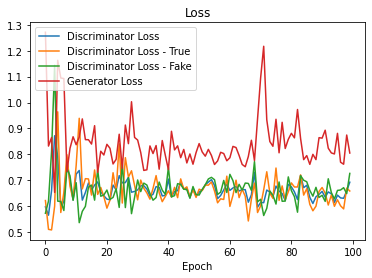

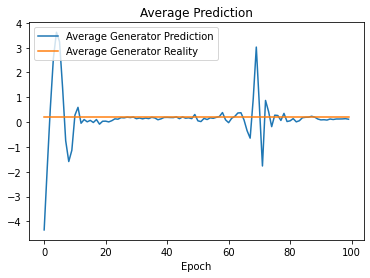

In [ ]:
plotting.plots(d_loss_err, d_loss_true, d_loss_fake, g_loss_err, g_pred, g_true, fig_dir, exp_config.run.save_fig)

In [ ]:
ypred_mean_gan_test, ypred_std_gan_test, ypred_gan_sample_test = cgan.sample(X_test, exp_config.training.n_samples)

8/8 [==============================] - 0s 2ms/step


In [ ]:
ypred_mean_gan_train, ypred_std_gan_train, ypred_gan_sample_train = cgan.sample(X_train, exp_config.training.n_samples)

886/886 [==============================] - 1s 1ms/step


In [ ]:
print(f"Train-RMSE: {mean_squared_error(y_train, ypred_mean_gan_train, squared=False).round(2)}, Train-R2: {r2_score(y_train, ypred_mean_gan_train).round(2)}")
print(f"Test-RMSE: {mean_squared_error(y_test, ypred_mean_gan_test, squared=False).round(2)}, Test-R2: {r2_score(y_test, ypred_mean_gan_test).round(2)}")

Train-RMSE: 0.81, Train-R2: -0.14
Test-RMSE: 0.47, Test-R2: -0.55


### Variance Prediction with CGAN

In [ ]:
print('GAN Variance-predicitions')
print(f"Test-RMSE: {mean_squared_error(tt.Y_test.scale, np.exp(0.5 * ypred_std_gan_test), squared=False).round(2)}, Test-R2: {r2_score(tt.Y_test.scale, np.exp(0.5 * ypred_std_gan_test)).round(2)}")

# NN

In [12]:
import keras

# dropout_rate = 0.1
# 16, 32, 128, 32, 16

# Comparable architecture to GAN 
model = keras.models.Sequential([
    keras.layers.Dense(16, activation="relu", input_shape=X_train.shape[1:]),
    # keras.layers.Dropout(dropout_rate), 
    keras.layers.Dense(32, activation="relu"),
    # keras.layers.Dropout(dropout_rate), 
    keras.layers.Dense(128, activation="relu"),
    # keras.layers.Dropout(dropout_rate),
    keras.layers.Dense(32, activation="relu"),
    # keras.layers.Dropout(dropout_rate),
    keras.layers.Dense(16, activation="relu"),
    # keras.layers.Dropout(dropout_rate),
    # keras.layers.Dense(50, activation="relu"),
    # keras.layers.Dropout(dropout_rate),
    # keras.layers.Dense(1, activation="relu"),
    keras.layers.Dense(1, activation="linear"),
])
model.compile(loss="mean_squared_error", optimizer=keras.optimizers.Adam(learning_rate=1e-5, decay=1e-4))

2022-11-16 23:12:36.131572: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-11-16 23:12:36.131662: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2022-11-16 23:12:36.131711: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (hub-kproc-prod-dataproc-hub-navish-iitkgp-m): /proc/driver/nvidia/version does not exist
2022-11-16 23:12:36.132402: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [13]:
# callbacks = [keras.callbacks.EarlyStopping(patience=10)]
history = model.fit(X_train, y_train,
                    validation_data=(X_test, y_test), epochs=100,)
                    # callbacks=callbacks)

Epoch 1/100
886/886 [==============================] - 8s 7ms/step - loss: 0.5254 - val_loss: 0.0637
Epoch 2/100
886/886 [==============================] - 5s 6ms/step - loss: 0.4967 - val_loss: 0.0587
Epoch 3/100
886/886 [==============================] - 5s 6ms/step - loss: 0.4890 - val_loss: 0.0587
Epoch 4/100
886/886 [==============================] - 6s 7ms/step - loss: 0.4853 - val_loss: 0.0536
Epoch 5/100
886/886 [==============================] - 5s 6ms/step - loss: 0.4818 - val_loss: 0.0564
Epoch 6/100
886/886 [==============================] - 5s 6ms/step - loss: 0.4801 - val_loss: 0.0568
Epoch 7/100
886/886 [==============================] - 5s 6ms/step - loss: 0.4777 - val_loss: 0.0568
Epoch 8/100
886/886 [==============================] - 6s 6ms/step - loss: 0.4760 - val_loss: 0.0583
Epoch 9/100
886/886 [==============================] - 5s 6ms/step - loss: 0.4747 - val_loss: 0.0545
Epoch 10/100
886/886 [==============================] - 4s 5ms/step - loss: 0.4730 - val_lo

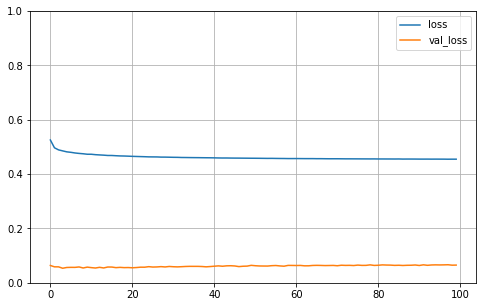

In [14]:
plotting.plot_learning_curves(history)

In [15]:
ypred_nn_train = model.predict(X_train)
ypred_nn_test = model.predict(X_test)

8/8 [==============================] - 0s 2ms/step


In [16]:
print(f"Train-RMSE: {mean_squared_error(y_train, ypred_nn_train, squared=False).round(2)}, Train-R2: {r2_score(y_train, ypred_nn_train).round(2)}")
print(f"Test-RMSE: {mean_squared_error(y_test, ypred_nn_test, squared=False).round(2)}, Test-R2: {r2_score(y_test, ypred_nn_test).round(2)}")

Train-RMSE: 0.67, Train-R2: 0.2
Test-RMSE: 0.26, Test-R2: 0.54


# GP

In [58]:
# !pip install gpytorch
# from torch.utils.data import TensorDataset, DataLoader
# train_dataset = TensorDataset(torch.Tensor(X_train), torch.Tensor(y_train))
# train_loader = DataLoader(train_dataset, batch_size=1024, shuffle=True)

# test_dataset = TensorDataset(torch.Tensor(X_test), torch.Tensor(y_test))
# test_loader = DataLoader(test_dataset, batch_size=1024, shuffle=False)

In [11]:
import math
import torch
import gpytorch


#  R2 =0.25, VAR = -.14
# We will use the simplest form of GP model, exact inference
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(torch.Tensor(X_train), torch.Tensor(y_train), likelihood)

In [12]:
# this is for running the notebook in our testing framework
import os
smoke_test = ('CI' in os.environ)
training_iter = 2 if smoke_test else 50


# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(torch.Tensor(X_train))
    # Calc loss and backprop gradients
    loss = -mll(output, torch.Tensor(y_train))
    loss.backward()
    print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
        i + 1, training_iter, loss.item(),
        model.covar_module.base_kernel.lengthscale.item(),
        model.likelihood.noise.item()
    ))
    optimizer.step()

Iter 1/50 - Loss: 1.115   lengthscale: 0.693   noise: 0.693
Iter 2/50 - Loss: 1.114   lengthscale: 0.698   noise: 0.688
Iter 3/50 - Loss: 1.113   lengthscale: 0.703   noise: 0.683
Iter 4/50 - Loss: 1.109   lengthscale: 0.708   noise: 0.678
Iter 5/50 - Loss: 1.110   lengthscale: 0.713   noise: 0.673
Iter 6/50 - Loss: 1.109   lengthscale: 0.718   noise: 0.669
Iter 7/50 - Loss: 1.107   lengthscale: 0.723   noise: 0.664
Iter 8/50 - Loss: 1.106   lengthscale: 0.728   noise: 0.659
Iter 9/50 - Loss: 1.107   lengthscale: 0.734   noise: 0.654
Iter 10/50 - Loss: 1.103   lengthscale: 0.739   noise: 0.649
Iter 11/50 - Loss: 1.102   lengthscale: 0.744   noise: 0.645
Iter 12/50 - Loss: 1.102   lengthscale: 0.749   noise: 0.640
Iter 13/50 - Loss: 1.101   lengthscale: 0.755   noise: 0.635
Iter 14/50 - Loss: 1.101   lengthscale: 0.760   noise: 0.631
Iter 15/50 - Loss: 1.100   lengthscale: 0.766   noise: 0.626
Iter 16/50 - Loss: 1.097   lengthscale: 0.771   noise: 0.622
Iter 17/50 - Loss: 1.097   length

KeyboardInterrupt: 

In [ ]:
f_preds = model(torch.Tensor(X_train))
y_preds = likelihood(model(torch.Tensor(X_train)))

f_mean = f_preds.mean
f_var = f_preds.variance
f_covar = f_preds.covariance_matrix
# f_samples = f_preds.sample(sample_shape=torch.Size(1000,))

In [ ]:

# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

# Test points are regularly spaced along [0,1]
# Make predictions by feeding model through likelihood
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    observed_pred = likelihood(model(torch.Tensor(X_test)))

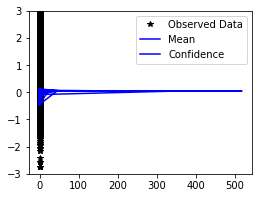

In [ ]:
with torch.no_grad():
    # Initialize plot
    f, ax = plt.subplots(1, 1, figsize=(4, 3))

    # Get upper and lower confidence bounds
    lower, upper = observed_pred.confidence_region()
    # Plot training data as black stars
    ax.plot(X_train[:,5], y_train, 'k*')
    # Plot predictive means as blue line
    ax.plot(X_test, observed_pred.mean.numpy(), 'b')
    # Shade between the lower and upper confidence bounds
    ax.fill_between(X_test[:,0], lower.numpy(), upper.numpy(), alpha=0.5)
    ax.set_ylim([-3, 3])
    ax.legend(['Observed Data', 'Mean', 'Confidence'])

In [ ]:
# ----------------- RBF ----------------- #
ypred_gp_rbf_train = y_preds.mean.detach().numpy()
ypred_gp_rbf_test, std_rbf_test = observed_pred.mean.numpy(), observed_pred.variance.numpy()**0.5

# # ----------------- RatQuad ----------------- #
# ypred_gp_quad_train, cov_quad_train = gpr_quad.predict(X_train)
# ypred_gp_quad_test, cov_quad_test = gpr_quad.predict(X_test)

#### RBF predictions

In [ ]:
print('Mean-predicitions')
print(f"Train-RMSE: {mean_squared_error(y_train, y_preds.mean.detach().numpy(), squared=False).round(2)}, Train-R2: {r2_score(y_train, y_preds.mean.detach().numpy()).round(2)}")
print(f"Test-RMSE: {mean_squared_error(y_test, observed_pred.mean.numpy(), squared=False).round(2)}, Test-R2: {r2_score(y_test, observed_pred.mean.numpy()).round(2)}\n")

print('Variance-predicitions')
print(f"Test-RMSE: {mean_squared_error(tt.Y_test.scale, observed_pred.variance.numpy()**0.5, squared=False).round(2)}, Test-R2: {r2_score(tt.Y_test.scale, observed_pred.variance.numpy()**0.5).round(2)}")

Mean-predicitions
Train-RMSE: 0.76, Train-R2: -0.0
Test-RMSE: 0.37, Test-R2: 0.01

Variance-predicitions
Test-RMSE: 0.5, Test-R2: -14.85


#### GridInterpolationKernel predictions

In [ ]:
# print('Mean-predicitions')
# print(f"Train-RMSE: {mean_squared_error(y_train, y_preds.mean.detach().numpy(), squared=False).round(2)}, Train-R2: {r2_score(y_train, y_preds.mean.detach().numpy()).round(2)}")
# print(f"Test-RMSE: {mean_squared_error(y_test, observed_pred.mean.numpy(), squared=False).round(2)}, Test-R2: {r2_score(y_test, observed_pred.mean.numpy()).round(2)}\n")

# print('Variance-predicitions')
# print(f"Test-RMSE: {mean_squared_error(tt.Y_test.scale, observed_pred.variance.numpy()**0.5, squared=False).round(2)}, Test-R2: {r2_score(tt.Y_test.scale, observed_pred.variance.numpy()**0.5).round(2)}")

Mean-predicitions
Train-RMSE: 0.77, Train-R2: -0.04
Test-RMSE: 0.33, Test-R2: 0.25

Variance-predicitions
Test-RMSE: 0.13, Test-R2: -0.14


# Plots

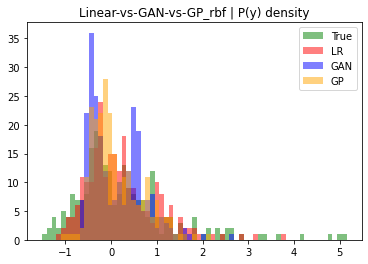

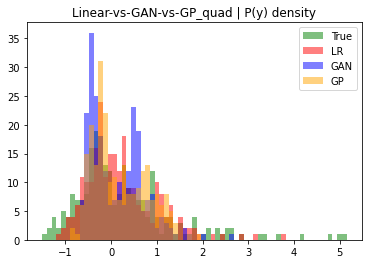

In [ ]:
# plotting.plot_densities_joint(y_test, ypred_nn_test, ypred_mean_gan_test, ypred_gp_test, 
#                              "Linear-vs-GAN-vs-GP P(y) density", fig_dir=fig_dir, 
#                              prefix="all_marginalized", save_fig=exp_config.run.save_fig, at_x=True)

plotting.plot_datadistrib_joint(y_test, ypred_nn_test, ypred_mean_gan_test, ypred_gp_rbf_test, 
                                "Linear-vs-GAN-vs-GP_rbf | P(y) density", fig_dir=fig_dir, 
                                prefix="all_marginalized", save_fig=exp_config.run.save_fig)

# plotting.plot_datadistrib_joint(y_test, ypred_nn_test, ypred_mean_gan_test, ypred_gp_quad_test, 
#                                 "Linear-vs-GAN-vs-GP_quad | P(y) density", fig_dir=fig_dir, 
#                                 prefix="all_marginalized", save_fig=exp_config.run.save_fig)

# Metrics

In [ ]:
n_eval_runs = 10

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

mse_gan_= []
mae_gan_ = []
r2_gan_ = []
for i in range(n_eval_runs):
    ypred_mean_gan_test_, ypred_median_gan_test_, _ = cgan.sample(X_test, exp_config.training.n_samples)
    mae_gan_.append(mean_absolute_error(y_test, ypred_median_gan_test_))
    mse_gan_.append(mean_squared_error(y_test, ypred_mean_gan_test_, squared=False))
    r2_gan_.append(r2_score(y_test, ypred_mean_gan_test_))

8/8 [==============================] - 0s 2ms/step


In [ ]:
nn_mae = mean_absolute_error(y_test, ypred_nn_test)
gp_rbf_mae = mean_absolute_error(y_test, ypred_gp_rbf_test)
gp_quad_mae = mean_absolute_error(y_test, ypred_gp_quad_test)
gan_mae_mean = np.mean(np.asarray(mae_gan_))
gan_mae_std = np.std(np.asarray(mae_gan_))

print(f"NN MAE test: {nn_mae}")
print(f"GP MAE test: RBF = {gp_rbf_mae}, QUAD = {gp_quad_mae}")
print(f"GAN MAE test: {gan_mae_mean} +- {gan_mae_std}")

NN MAE test: 0.5718941009207605
GP MAE test: RBF = 0.6662740466446093, QUAD = 0.6308358479949356
GAN MAE test: 0.6276623772377045 +- 0.003605090236830058


In [ ]:
nn_mse = mean_squared_error(y_test, ypred_nn_test).round(2)
gp_rbf_mse = mean_squared_error(y_test, ypred_gp_rbf_test).round(2)
gp_quad_mse = mean_squared_error(y_test, ypred_gp_quad_test).round(2)
gan_mse_mean = np.mean(np.asarray(mse_gan_)).round(2)
gan_mse_std = np.std(np.asarray(mse_gan_)).round(2)
# mdn_mse_mean = np.mean(np.asarray(mse_mdn_))
# mdn_mse_std = np.std(np.asarray(mse_mdn_))

print(f"NN MSE test: {nn_mse}")
print(f"GP MSE test: RBF = {gp_rbf_mse}, QUAD = {gp_quad_mse}")
print(f"GAN MSE test: {gan_mse_mean} +- {gan_mse_std}")
# print(f"MDN MSE test: {mdn_mse_mean} +- {mdn_mse_std}")

NN MSE test: 0.59
GP MSE test: RBF = 1.04, QUAD = 0.84
GAN MSE test: 0.89 +- 0.0


In [ ]:
nn_r2 = r2_score(y_test, ypred_nn_test).round(2)
gp_rbf_r2 = r2_score(y_test, ypred_gp_rbf_test).round(2)
gp_quad_r2 = r2_score(y_test, ypred_gp_quad_test).round(2)
gan_r2_mean = np.mean(np.asarray(r2_gan_)).round(2)
gan_r2_std = np.std(np.asarray(r2_gan_)).round(2)

print(f"NN R2 test: {nn_r2}")
print(f"GP R2 test: RBF = {gp_rbf_r2}, QUAD = {gp_quad_r2}")
print(f"GAN R2 test: {gan_r2_mean} +- {gan_r2_std}")
# print(f"MDN MSE test: {mdn_mse_mean} +- {mdn_mse_std}")

NN R2 test: 0.51
GP R2 test: RBF = 0.12, QUAD = 0.29
GAN R2 test: 0.33 +- 0.0


In [ ]:
cov_nn = np.mean((y_test - ypred_nn_test)**2)
nn_nlpd = metrics.gaussian_NLPD(y_test, ypred_nn_test, np.ones(len(ypred_nn_test)) * cov_nn, "NN")

NN Gaussian NLPD: 1.3706085406456683


In [ ]:
gp_rbf_nlpd = metrics.gaussian_NLPD(y_test, ypred_gp_rbf_test, cov_rbf_train, "GP-RBF")
gp_quad_nlpd = metrics.gaussian_NLPD(y_test, ypred_gp_quad_test, cov_quad_train, "GP-QUAD")

GP-RBF Gaussian NLPD: 1.7281478367684642
GP-QUAD Gaussian NLPD: 1.5208828884339085


In [ ]:
gan_nlpd_train, w, lls = metrics.Parzen(cgan, X_train, y_train, n_sample=exp_config.training.n_samples)
nlpd_ = []
for i in range(n_eval_runs):
    nlpd_.append(metrics.Parzen_test(cgan, X_test, y_test, w, exp_config.training.n_samples))
gan_nlpd_test = np.mean(nlpd_)
gan_nlpd_std_test = np.std(nlpd_)

2/2 [==============================] - 0s 4ms/step


In [ ]:
print(f"GAN Train NLLH: {gan_nlpd_train}")
print(f"GAN Test NLLH: mean {gan_nlpd_test} std {gan_nlpd_std_test}")

GAN Train NLLH: 1.0688424955559799
GAN Test NLLH: mean 1.405695862654206 std 0.008065419764411764


In [ ]:
if exp_config.run.save_fig:
    file = open(f"{fig_dir}/metrics.txt","w") 

    file.write(f"===Test MAE===\n")
    file.write(f"NN MAE test: {nn_mae}\n") 
    file.write(f"GP MAE test: RBF = {gp_rbf_mae}, QUAD = {gp_quad_mae}\n")
    file.write(f"GAN MAE test: {gan_mae_mean} +- {gan_mae_std}\n")
    file.write(f"===Test MSE===\n")
    file.write(f"NN MSE test: {nn_mse}\n")
    file.write(f"GP MSE test: RBF = {gp_rbf_mse}, QUAD = {gp_quad_mse}\n")
    file.write(f"GAN MSE test: {gan_mse_mean} +- {gan_mse_std}\n")
    file.write(f"===Test R2===\n")
    file.write(f"NN R2 test: {nn_r2}\n")
    file.write(f"GP R2 test: RBF = {gp_rbf_r2}, QUAD = {gp_quad_r2}\n")
    file.write(f"GAN R2 test: {gan_r2_mean} +- {gan_r2_std}\n")
    file.write(f"===Test NLPD===\n")
    file.write(f"NN Gaussian NLPD: {nn_nlpd}\n")
    file.write(f"GP Gaussian NLPD: RBF = {gp_rbf_nlpd}, QUAD = {gp_quad_nlpd}\n")
    file.write(f"GAN NLPD: {gan_nlpd_test} +- {gan_nlpd_std_test}\n")
    file.close() 

In [ ]:
ypred_mean_gan_train.shape

(957, 1)

In [ ]:
# Training covariances
cov_nn_train = np.mean((y_train - ypred_nn_train)**2)
cov_xgb_train = np.mean((y_train - ypred_xgb_train)**2)

# ----------------- Finding Training Losses -----------------
nn_r2_train, nn_mse_train, nn_mae_train, nn_nlpd_train = r2_score(y_train, ypred_nn_train), mean_squared_error(y_train, ypred_nn_train), mean_absolute_error(y_train, ypred_nn_train), metrics.gaussian_NLPD(y_train, ypred_nn_train, np.ones(len(ypred_nn_train)) * cov_nn_train, "NN")
gp_rbf_r2_train, gp_rbf_mse_train, gp_rbf_mae_train, gp_rbf_nlpd_train = r2_score(y_train, ypred_gp_rbf_train), mean_squared_error(y_train, ypred_gp_rbf_train), mean_absolute_error(y_train, ypred_gp_rbf_train), metrics.gaussian_NLPD(y_train, ypred_gp_rbf_train, cov_rbf_train, "GP-RBF")
gp_quad_r2_train, gp_quad_mse_train, gp_quad_mae_train, gp_quad_nlpd_train = r2_score(y_train, ypred_gp_quad_train), mean_squared_error(y_train, ypred_gp_quad_train), mean_absolute_error(y_train, ypred_gp_quad_train), metrics.gaussian_NLPD(y_train, ypred_gp_quad_train, cov_quad_train, "GP-QUAD")
gan_r2_train, gan_mse_train, gan_mae_train, gan_nlpd_train = r2_score(y_train, ypred_mean_gan_train), mean_squared_error(y_train, ypred_mean_gan_train), mean_absolute_error(y_train, ypred_mean_gan_train), gan_nlpd_train
xgb_r2_train, xgb_mse_train, xgb_mae_train, xgb_nlpd_train = r2_score(y_train, ypred_xgb_train), mean_squared_error(y_train, ypred_xgb_train), mean_absolute_error(y_train, ypred_xgb_train), metrics.gaussian_NLPD(y_train, ypred_xgb_train, np.ones(len(ypred_xgb_train)) * cov_xgb_train, "XGB")

# ----------------- Finding Test Losses for XGBOOST -----------------
cov_xgb_test = np.mean((y_test - ypred_xg_test)**2)
xgb_r2, xgb_mse, xgb_mae, xgb_nlpd = r2_score(y_test, ypred_xg_test), mean_squared_error(y_test, ypred_xg_test), mean_absolute_error(y_test, ypred_xg_test), metrics.gaussian_NLPD(y_test, ypred_xg_test, np.ones(len(ypred_xg_test)) * cov_xgb_test, "XGB")

results = {
    "NN": {'Train': {'R2':nn_r2_train.round(2), "RMSE":nn_mse_train.round(2), "MAE":nn_mae_train.round(2), "NLPD":nn_nlpd_train.round(2)}, 'Test': {'R2':nn_r2.round(2), "RMSE":nn_mse.round(2), "MAE":nn_mae.round(2), "NLPD":nn_nlpd.round(2)}},
    "GP-RBF": {'Train': {'R2':gp_rbf_r2_train.round(2), "RMSE":gp_rbf_mse_train.round(2), "MAE":gp_rbf_mae_train.round(2), "NLPD":gp_rbf_nlpd_train.round(2)}, 'Test': {'R2':gp_rbf_r2.round(2), "RMSE":gp_rbf_mse.round(2), "MAE":gp_rbf_mae.round(2), "NLPD":gp_rbf_nlpd.round(2)}},
    "GP-QUAD": {'Train': {'R2':gp_quad_r2_train.round(2), "RMSE":gp_quad_mse_train.round(2), "MAE":gp_quad_mae_train.round(2), "NLPD":gp_quad_nlpd_train.round(2)}, 'Test': {'R2':gp_quad_r2.round(2), "RMSE":gp_quad_mse.round(2), "MAE":gp_quad_mae.round(2), "NLPD":gp_quad_nlpd.round(2)}},
    "CGAN": {'Train': {'R2':gan_r2_train.round(2), "RMSE":gan_mse_train.round(2), "MAE":gan_mae_train.round(2), "NLPD":gan_nlpd_train.round(2)}, 'Test': {'R2':gan_r2_mean.round(2), "RMSE":gan_mse_mean.round(2), "MAE":gan_mae_mean.round(2), "NLPD":gan_nlpd_test.round(2)}},
    "XGB": {'Train': {'R2':xgb_r2_train.round(2), "RMSE":xgb_mse_train.round(2), "MAE":xgb_mae_train.round(2), "NLPD":xgb_nlpd_train.round(2)}, 'Test': {'R2':xgb_r2.round(2), "RMSE":xgb_mse.round(2), "MAE":xgb_mae.round(2), "NLPD":xgb_nlpd.round(2)}},
}

NN Gaussian NLPD: 1.1458503378402647
GP-RBF Gaussian NLPD: 0.7350849333122246
GP-QUAD Gaussian NLPD: 0.6757093193808699
XGB Gaussian NLPD: 0.5952350083130847
XGB Gaussian NLPD: 1.0762571696533683


In [ ]:
pd.DataFrame.from_dict({(i,j): results[i][j] 
                           for i in results.keys() 
                           for j in results[i].keys()},
                       orient='index')

R2  RMSE   MAE  NLPD
NN      Train  0.72  0.23  0.35  1.15
        Test   0.51  0.59  0.57  1.37
GP-RBF  Train  0.74  0.22  0.35  0.74
        Test   0.12  1.04  0.67  1.73
GP-QUAD Train  0.78  0.18  0.33  0.68
        Test   0.29  0.84  0.63  1.52
CGAN    Train  0.44  0.46  0.51  1.07
        Test   0.33  0.89  0.63  1.41
XGB     Train  0.76  0.19  0.34  0.60
        Test   0.58  0.50  0.52  1.08